Brandon Huegerich 800909207

install wget with command "pip install wget". Using comand to install SpaCy: "pip install -U spacy"

In [1]:
import numpy as np
import pandas as pd
import wget
import os
import zipfile
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [7]:
url4 = 'https://raw.githubusercontent.com/google-research-datasets/gap-coreference/master/gap-development.tsv'
GAP_test = wget.download(url4)
GAP_test
url5 = 'https://raw.githubusercontent.com/google-research-datasets/gap-coreference/master/gap-test.tsv'
GAP_train = wget.download(url5)
GAP_train
url16 = 'https://raw.githubusercontent.com/google-research-datasets/gap-coreference/master/gap-validation.tsv'
GAP_val = wget.download(url16)
GAP_val

'gap-validation.tsv'

In [8]:
test_df  = pd.read_table(GAP_test)
train_df = pd.read_table(GAP_train)
val_df   = pd.read_table(GAP_val)

train_df.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,test-1,Upon their acceptance into the Kontinental Hoc...,His,383,Bob Suter,352,False,Dehner,366,True,http://en.wikipedia.org/wiki/Jeremy_Dehner
1,test-2,"Between the years 1979-1981, River won four lo...",him,430,Alonso,353,True,Alfredo Di St*fano,390,False,http://en.wikipedia.org/wiki/Norberto_Alonso
2,test-3,Though his emigration from the country has aff...,He,312,Ali Aladhadh,256,True,Saddam,295,False,http://en.wikipedia.org/wiki/Aladhadh
3,test-4,"At the trial, Pisciotta said: ``Those who have...",his,526,Alliata,377,False,Pisciotta,536,True,http://en.wikipedia.org/wiki/Gaspare_Pisciotta
4,test-5,It is about a pair of United States Navy shore...,his,406,Eddie,421,True,Rock Reilly,559,False,http://en.wikipedia.org/wiki/Chasers


In [9]:
train_df = pd.concat((train_df, val_df)).rename(columns={'A': 'A_Noun', 'B': 'B_Noun'}).reset_index(drop=True)

In [10]:
#This code is borrowed from https://www.kaggle.com/shujian/ml-model-example-with-train-test

#in string s replace r1 with r2
def name_replace(s, r1, r2):
    s = str(s).replace(r1,r2)
    for r3 in r1.split(' '):
        s = str(s).replace(r3,r2)
    return s

def get_features(df):
    df['section_min'] = df[['Pronoun-offset', 'A-offset', 'B-offset']].min(axis=1)
    df['Pronoun-offset2'] = df['Pronoun-offset'] + df['Pronoun'].map(len)
    df['A-offset2'] = df['A-offset'] + df['A_Noun'].map(len)
    df['B-offset2'] = df['B-offset'] + df['B_Noun'].map(len)                               
    df['section_max'] = df[['Pronoun-offset2', 'A-offset2', 'B-offset2']].max(axis=1)
    
    df['Text'] = df.apply(lambda r: name_replace(r['Text'], r['A_Noun'], 'subjectone'), axis=1)
    df['Text'] = df.apply(lambda r: name_replace(r['Text'], r['B_Noun'], 'subjecttwo'), axis=1)
    
    
    df['A-dist'] = (df['Pronoun-offset'] - df['A-offset']).abs()
    df['B-dist'] = (df['Pronoun-offset'] - df['B-offset']).abs()
    return(df)

train = get_features(train_df)
test = pd.read_csv('test_stage_1.tsv', delimiter='\t').rename(columns={'A': 'A_Noun', 'B': 'B_Noun'})
test = get_features(test)
test.head()

,ID,Text,Pronoun,Pronoun-offset,A_Noun,A-offset,B_Noun,B-offset,URL,section_min,Pronoun-offset2,A-offset2,B-offset2,section_max,A-dist,B-dist
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,Pauline,207,http://en.wikipedia.org/wiki/List_of_Teachers_...,191,277,205,214,277,83,67
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,Bernard Leach,251,http://en.wikipedia.org/wiki/Warren_MacKenzie,228,287,237,264,287,56,33
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,De la Sota,246,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...,173,268,180,256,268,92,19
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,Henry Rosenthal,336,http://en.wikipedia.org/wiki/Crime_(band),174,324,178,351,351,147,15
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,Rivera,294,http://en.wikipedia.org/wiki/Jessica_Rivera,219,440,236,300,440,218,143


In [11]:
def get_nlp_features(s, w):
    doc = nlp(str(s))
    tokens = pd.DataFrame([[token.text, token.dep_] for token in doc], columns=['text', 'dep'])
    return len(tokens[((tokens['text']==w) & (tokens['dep']=='poss'))])

train['A-poss'] = train['Text'].map(lambda x: get_nlp_features(x, 'subjectone'))
train['B-poss'] = train['Text'].map(lambda x: get_nlp_features(x, 'subjecttwo'))
test['A-poss'] = test['Text'].map(lambda x: get_nlp_features(x, 'subjectone'))
test['B-poss'] = test['Text'].map(lambda x: get_nlp_features(x, 'subjecttwo'))

train = train.rename(columns={'A-coref':'A', 'B-coref':'B'})
train['A'] = train['A'].astype(int)
train['B'] = train['B'].astype(int)
train['NEITHER'] = 1.0 - (train['A'] + train['B'])

In [28]:
from sklearn.model_selection import train_test_split
col = ['Pronoun-offset', 'A-offset', 'B-offset', 'section_min', 'Pronoun-offset2', 'A-offset2', 'B-offset2', 'section_max', 'A-poss', 'B-poss', 'A-dist', 'B-dist']
x1, x2, y1, y2 = train_test_split(train[col].fillna(-1), train[['A', 'B', 'NEITHER']], test_size=0.2, random_state=1)

Text(0, 0.5, 'Testing Accuracy')

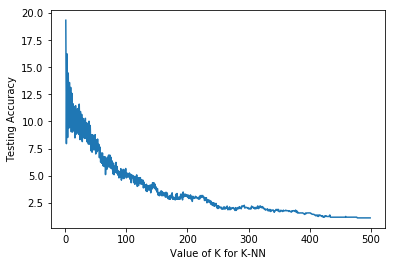

In [29]:
from sklearn import *
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

k_range = range(1, 500)
score = []
for k in k_range:
    modelNeigh = KNeighborsClassifier(n_neighbors=k)
    modelNeigh.fit(x1, y1)
    score.append(metrics.log_loss(y2, modelNeigh.predict(x2)))

%matplotlib inline
plt.plot(k_range, score)
plt.xlabel('Value of K for K-NN')
plt.ylabel('Testing Accuracy')

In [37]:
score[275]

1.9258184269079925

0.926133626179194

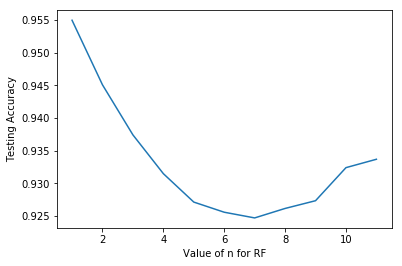

In [42]:
from sklearn.ensemble import RandomForestClassifier

#selecting the correct depth
n_range = range(1, 12)
loss = []
for n in n_range:
    modelForest = multiclass.OneVsRestClassifier(ensemble.RandomForestClassifier(max_depth = n, n_estimators=1000, random_state=2))
    modelForest.fit(x1, y1)
    loss.append(metrics.log_loss(y2, modelForest.predict_proba(x2)))
    
%matplotlib inline
plt.plot(n_range, loss)
plt.xlabel('Value of n for RF')
plt.ylabel('Testing Accuracy')
loss[7]